In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(SeuratData)
    #library(CelliD)
    library(readr)
}))

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [4]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [5]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated_wo_guide_calls.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


# Visualization


Use only singlets

In [6]:
seurat_combined_singlets <- subset(seurat_combined, subset = status == 'singlet')

### Check if libraries, donors or mito conents drive clustering

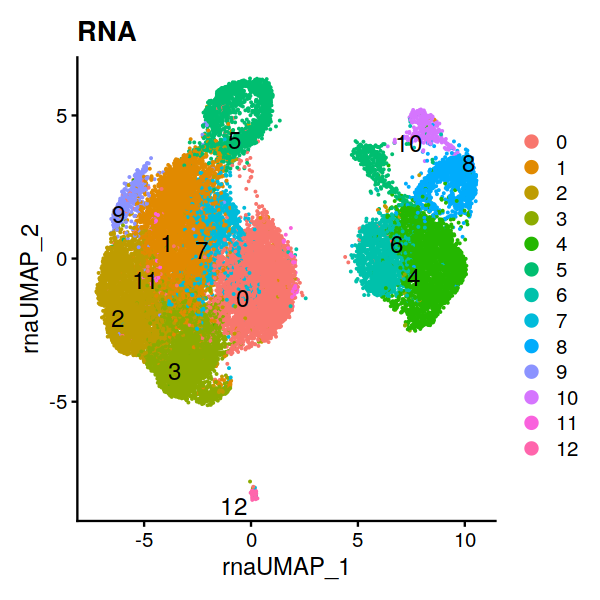

In [7]:
p1 <- DimPlot(seurat_combined_singlets, reduction = "umap.rna",  label = TRUE, label.size = 5, repel = TRUE) + ggtitle("RNA")
options(repr.plot.width=5, repr.plot.height=5)
p1

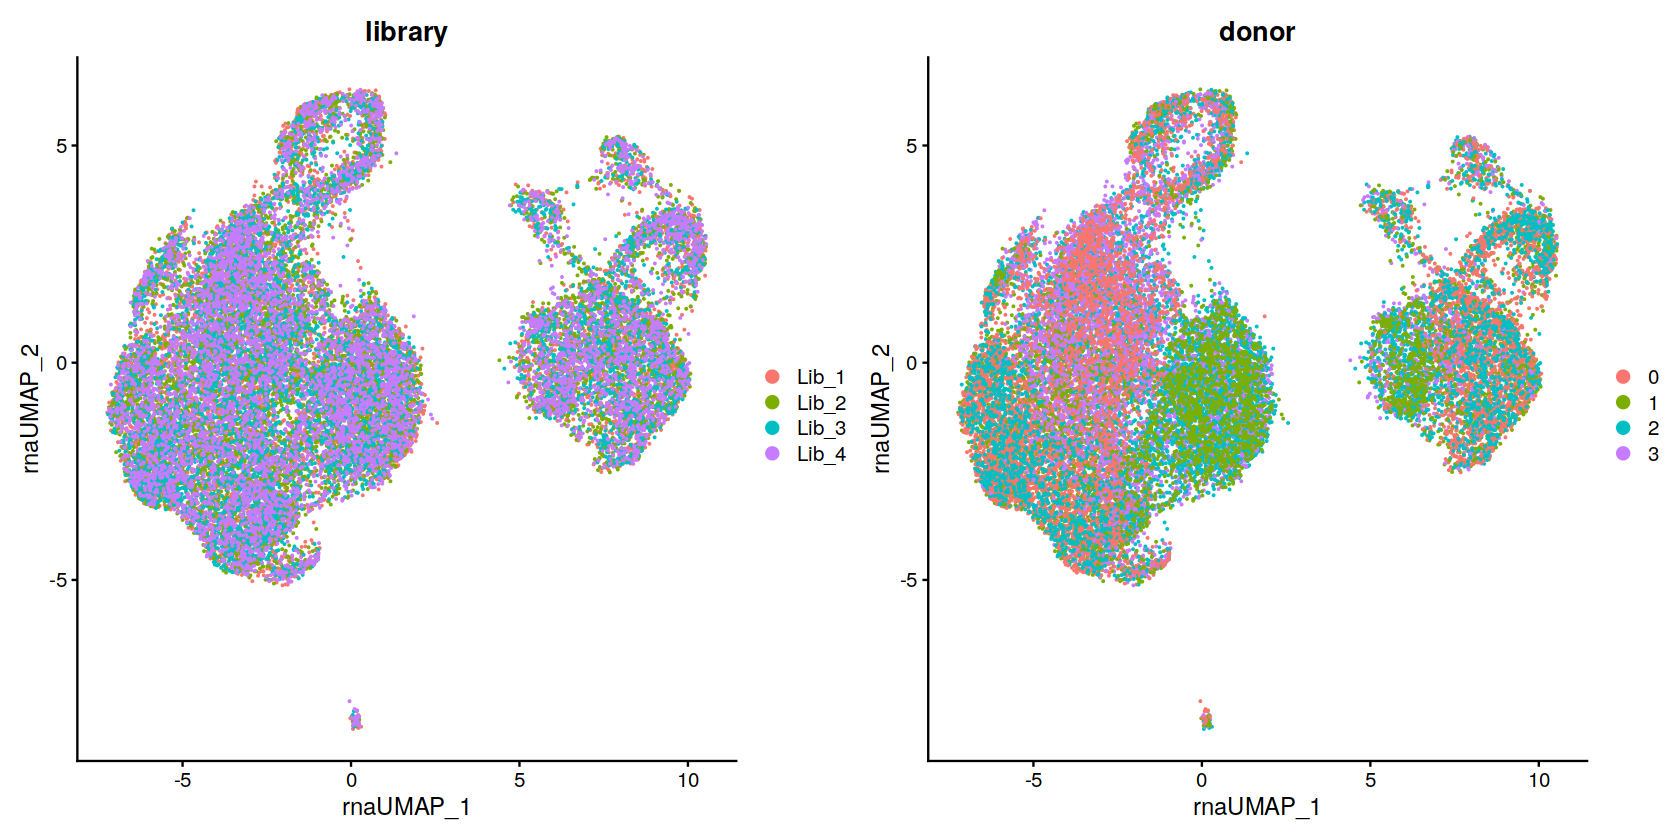

In [8]:
options(repr.plot.width=14, repr.plot.height=7)

p1 <- DimPlot(seurat_combined_singlets, reduction = "umap.rna", group.by = 'library')
p2 <- DimPlot(seurat_combined_singlets, reduction = "umap.rna", group.by = 'donor', label = FALSE)
p1 + p2

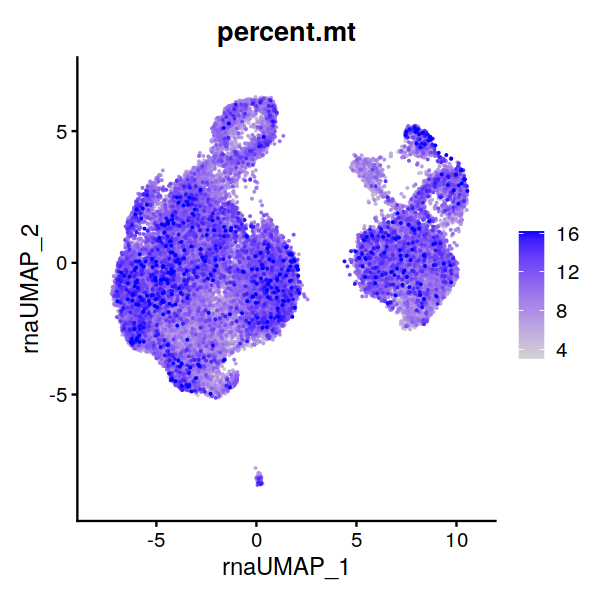

In [9]:
options(repr.plot.width=5, repr.plot.height=5)
FeaturePlot(seurat_combined_singlets, reduction= "umap.rna", features = c("percent.mt"), min.cutoff = NA, max.cutoff = "q99", order=T)

### Plot some distal tubular markers

Warning message in FeaturePlot(seurat_combined_singlets, reduction = "umap.rna", :
"All cells have the same value (0) of AVPR2."


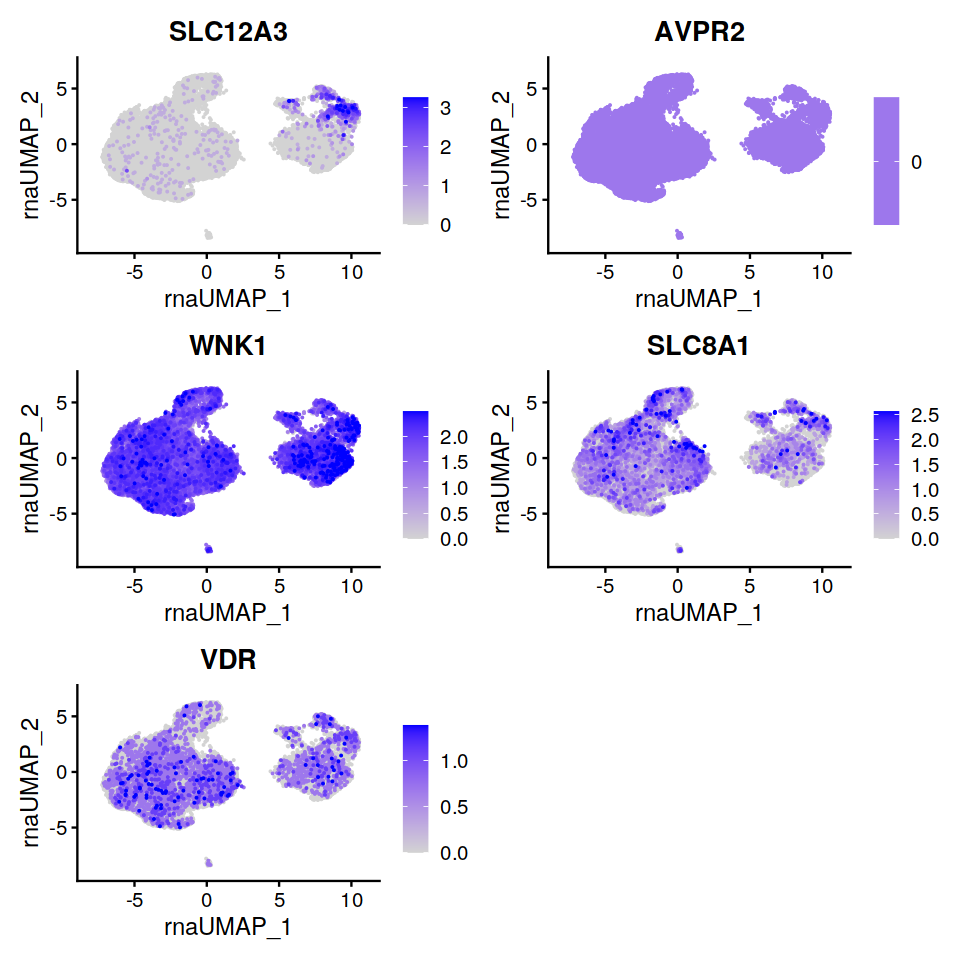

In [10]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(
    seurat_combined_singlets, 
    reduction= "umap.rna", 
    features = c("SLC12A3", "AVPR2", "WNK1", 'SLC8A1', 'VDR'), 
    min.cutoff = NA, 
    max.cutoff = "q99", order=T)

### Plot some proximal tubular markers

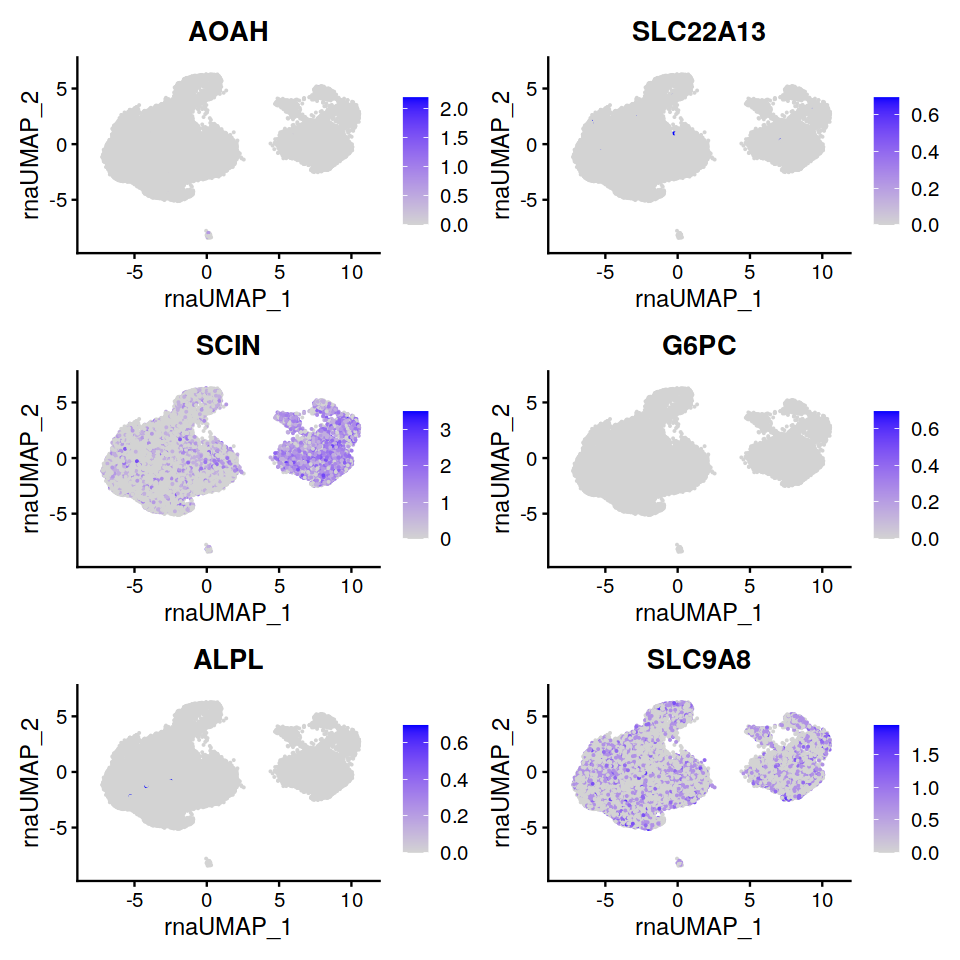

In [11]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(
    seurat_combined_singlets, 
    reduction= "umap.rna", 
    features = c("AOAH", "SLC22A13", "SCIN", "G6PC", "ALPL", "SLC9A8"))
    #min.cutoff = NA, 
    #max.cutoff = "q95", order=T)

### Plot TSS controls

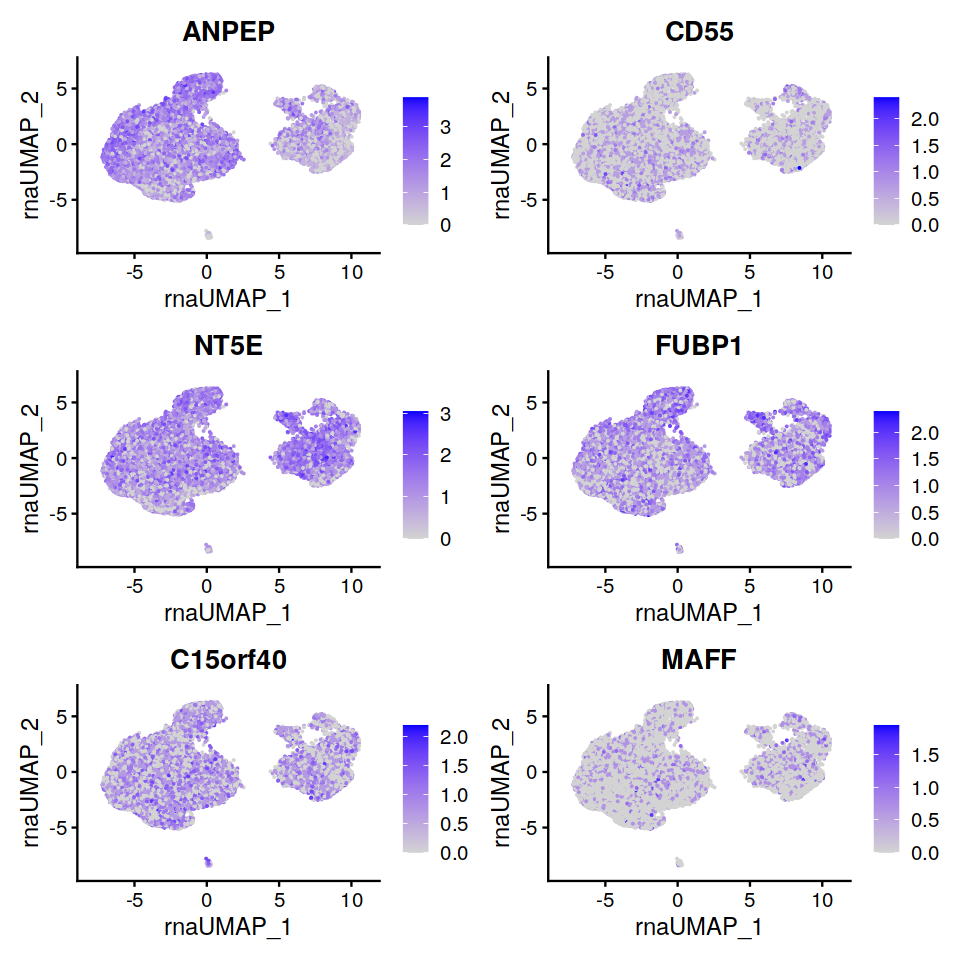

In [12]:
options(repr.plot.width=8, repr.plot.height=8)
FeaturePlot(
    seurat_combined_singlets, 
    reduction= "umap.rna", 
    features = c("ANPEP", "CD55", "NT5E", "FUBP1", "C15orf40", "MAFF")
)
    #min.cutoff = NA, 
    #max.cutoff = "q95", order=T)

# Construct+/- counts

Create a cell/target df

In [13]:
all_construct_calls = paste0(as.vector(seurat_combined_singlets$construct_call), collapse="|")
all_construct_calls = strsplit(all_construct_calls, split = "\\|")
df_construct_counts = as.data.frame(table(head(all_construct_calls)))
colnames(df_construct_counts) <- c("Construct", "Count")

ERROR: Error: Cannot find 'construct_call' in this Seurat object


In [ ]:
head(df_construct_counts, 2)

Construct  Count
1 C15orf40_1 1285 
2 CCCE1_1    1354

How many cells are there caryying each construct?

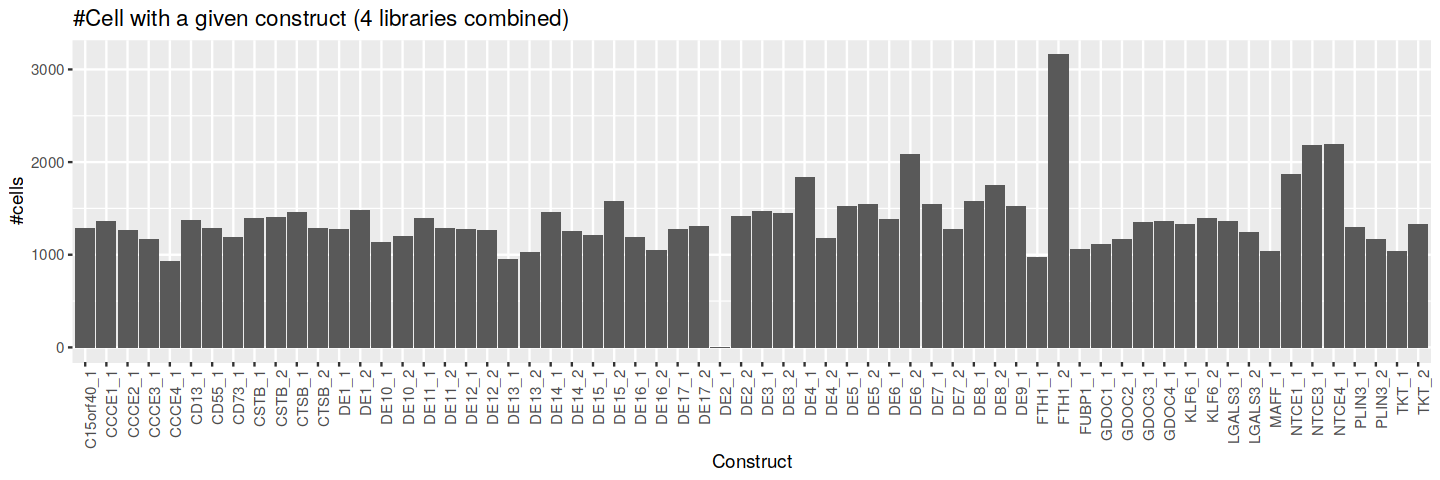

In [ ]:
p6 <- ggplot(df_construct_counts, aes(x = Construct,y = Count))+
    geom_bar(stat='identity') +
    labs(title = "#Cell with a given construct (4 libraries combined)", x = "Construct") +
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(y = "#cells") 

options(repr.plot.width=12, repr.plot.height=4)
p6

What is the number of singlets after integration?

In [ ]:
length(Cells(seurat_combined_singlets))

[1] 21363

What's the number of singlets+doublets

In [ ]:
length(Cells((seurat_combined)))

[1] 24563

### more viz

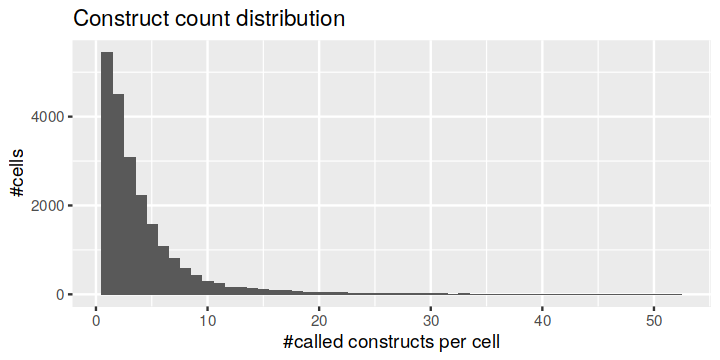

In [ ]:
df_metadata = seurat_combined_singlets@meta.data

p5 <- ggplot(df_metadata, aes(x = nCalled_Constructs)) +
    geom_histogram(binwidth=1) +
    labs(title = "Construct count distribution", x = "#called constructs per cell") +
    labs(y = "#cells") 


options(repr.plot.width=6, repr.plot.height=3)
p5


# Cell ID

In [14]:
get_cell_ids <- function(seurat_obj, cluster_id, max_minuslog10_q_val = 4, output_dir){
    if (cluster_id == "ALL_CELLS"){
        subset_seurat <- seurat_obj
    }
    else {
        subset_seurat  <- subset(x = seurat_obj, seurat_clusters == cluster_id)
    }
    HGT_all_gs <- RunCellHGT(subset_seurat, pathways = all_gs, dims = 1:30)
    
    all_gs_prediction <- rownames(HGT_all_gs)[apply(HGT_all_gs, 2, which.max)]
    all_gs_prediction_signif <- ifelse(
        apply(HGT_all_gs, 2, max) > max_minuslog10_q_val, 
        yes = all_gs_prediction, 
        "unassigned"
    )
    cell_count <- length(all_gs_prediction)
    plot_title <- paste("Cluster", cluster_id, ",", cell_count, "cells", ", q < 1e-", max_minuslog10_q_val)
    file_name  <- paste0("Cluster_", cluster_id, "__q_1e-", max_minuslog10_q_val,".png")
    options(repr.plot.width=8, repr.plot.height=5)
    par(las=3)
    par(mar=c(17,5,1,1))

    select_assigned          = all_gs_prediction_signif != 'unassigned'
    all_gs_prediction_signif = all_gs_prediction_signif[select_assigned]

    pred_table <- sort(table(all_gs_prediction_signif))
    #pred_table <- t(as.matrix(as.data.frame(pred_table)))
    barplot(pred_table, 
         main=plot_title,
         xlab = "",
         ylab = "#cells",
         cex.axis = 1.5,
         cex.lab = 1.5,
         cex.names = 1.5,
         cex.main = 1.5
    )

     
    cur_dir <- getwd()
    setwd(output_dir)
    png(file_name, width=600, height=350)
    par(las=3)
    par(mar=c(13,5,1,1))
    barplot(pred_table, main=plot_title)
    dev.off()
    setwd(cur_dir)
    pred_table
}

## Setup Panglao DB

download all cell-type gene signatures from panglaoDB

In [15]:
panglao <- read_tsv("https://panglaodb.se/markers/PanglaoDB_markers_27_Mar_2020.tsv.gz")
#filter to get human specific genes
panglao_all <- panglao %>%  filter(str_detect(species,"Hs"))

# convert dataframes to a list of named vectors which is the format for CelliD input
panglao_all <- panglao_all %>%  
  group_by(`cell type`) %>%  
  summarise(geneset = list(`official gene symbol`))
all_gs <- setNames(panglao_all$geneset, panglao_all$`cell type`)

#remove very short signatures
all_gs <- all_gs[sapply(all_gs, length) >= 10]

Rows: 8286 Columns: 14
── Column specification ─────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): species, official gene symbol, cell type, nicknames, product descri...
dbl (6): ubiquitousness index, canonical marker, sensitivity_human, sensitiv...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Run MCA

In [16]:
DefaultAssay(seurat_combined_singlets) <- "SCT"
seurat_combined_singlets <- RunMCA(seurat_combined_singlets, nmsc=1:30)

ERROR: Error in RunMCA(seurat_combined_singlets, nmsc = 1:30): could not find function "RunMCA"



calculating distance


ranking genes

136 pathways kept for hypergeometric test out of 151, 15 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test



calculating distance


ranking genes

136 pathways kept for hypergeometric test out of 151, 15 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test




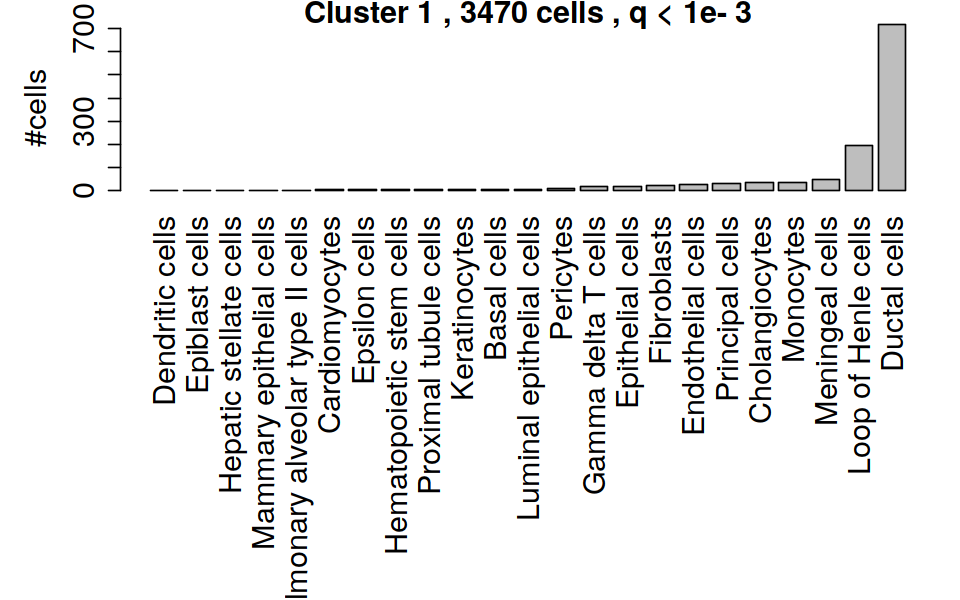

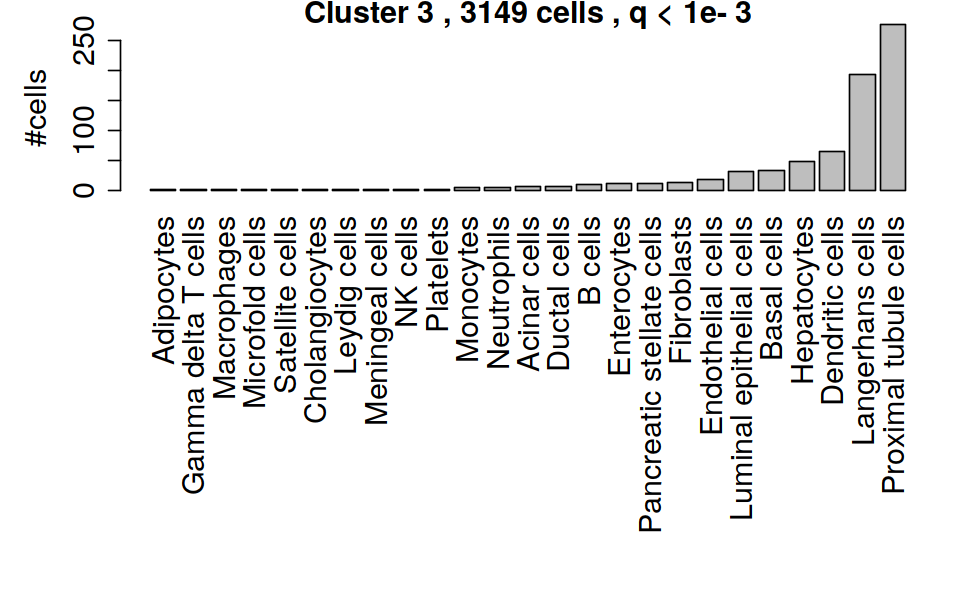

In [ ]:
max_q_val  <- 3
#cluster_id <- "ALL_CELLS"
cluster_id <- '1'
cellid_output_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated"
pred_table <- get_cell_ids(seurat_combined_singlets, cluster_id, max_q_val, cellid_output_path)

cluster_id <- '3'
cellid_output_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated"
pred_table <- get_cell_ids(seurat_combined_singlets, cluster_id, max_q_val, cellid_output_path)


calculating distance


ranking genes

136 pathways kept for hypergeometric test out of 151, 15 filtered as less than 10 features was present in the data


calculating features overlap


performing hypergeometric test




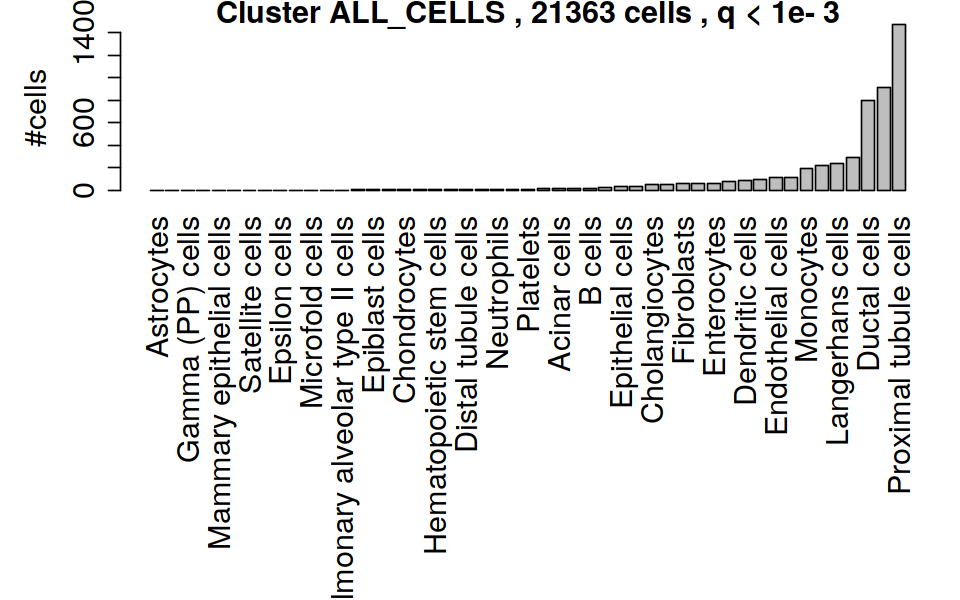

In [ ]:
cluster_id <- "ALL_CELLS"
cellid_output_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated"
pred_table <- get_cell_ids(seurat_combined_singlets, cluster_id, max_q_val, cellid_output_path)

# Find marker genes for all clusters

In [ ]:
# Find markers for all clusters
all_markers <- FindAllMarkers(object = seurat_combined_singlets)
head(x = all_markers)



Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11



p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene     
CDH6      0     1.11       0.99  0.92  0         0       CDH6     
NALCN-AS1 0     1.10       0.71  0.42  0         0       NALCN-AS1
LINC01611 0     1.06       0.76  0.45  0         0       LINC01611
NRCAM     0     1.01       1.00  0.96  0         0       NRCAM    
SLC6A6    0     1.01       0.94  0.83  0         0       SLC6A6   
FAM107B   0     0.97       0.97  0.91  0         0       FAM107B

In [ ]:
for(cluster_id in unique(all_markers$cluster)) {
    print(head(subset(all_markers, subset = cluster == cluster_id), 10))
}

          p_val avg_log2FC pct.1 pct.2 p_val_adj cluster      gene
CDH6          0       1.11  0.99  0.92         0       0      CDH6
NALCN-AS1     0       1.10  0.71  0.42         0       0 NALCN-AS1
LINC01611     0       1.06  0.76  0.45         0       0 LINC01611
NRCAM         0       1.01  1.00  0.96         0       0     NRCAM
SLC6A6        0       1.01  0.94  0.83         0       0    SLC6A6
FAM107B       0       0.97  0.97  0.91         0       0   FAM107B
CASC19        0       0.94  0.98  0.92         0       0    CASC19
FRMD5         0       0.91  0.89  0.71         0       0     FRMD5
LINC01705     0       0.88  0.96  0.92         0       0 LINC01705
RRAS2         0       0.88  0.99  0.96         0       0     RRAS2
         p_val avg_log2FC pct.1 pct.2 p_val_adj cluster    gene
ERBB4.1      0        2.9  0.86  0.13         0       1   ERBB4
KCNIP4.1     0        2.6  0.96  0.41         0       1  KCNIP4
MECOM.1      0        2.5  0.97  0.31         0       1   MECOM
WFDC2.1

In [ ]:
top_100 <- VariableFeatures(seurat_combined_singlets)[1:100]
top_50 <- VariableFeatures(seurat_combined_singlets)[1:50]
second_50 <- VariableFeatures(seurat_combined_singlets)[51:100]
top_40 <- VariableFeatures(seurat_combined_singlets)[1:40]

### Plot top 50 variable genes

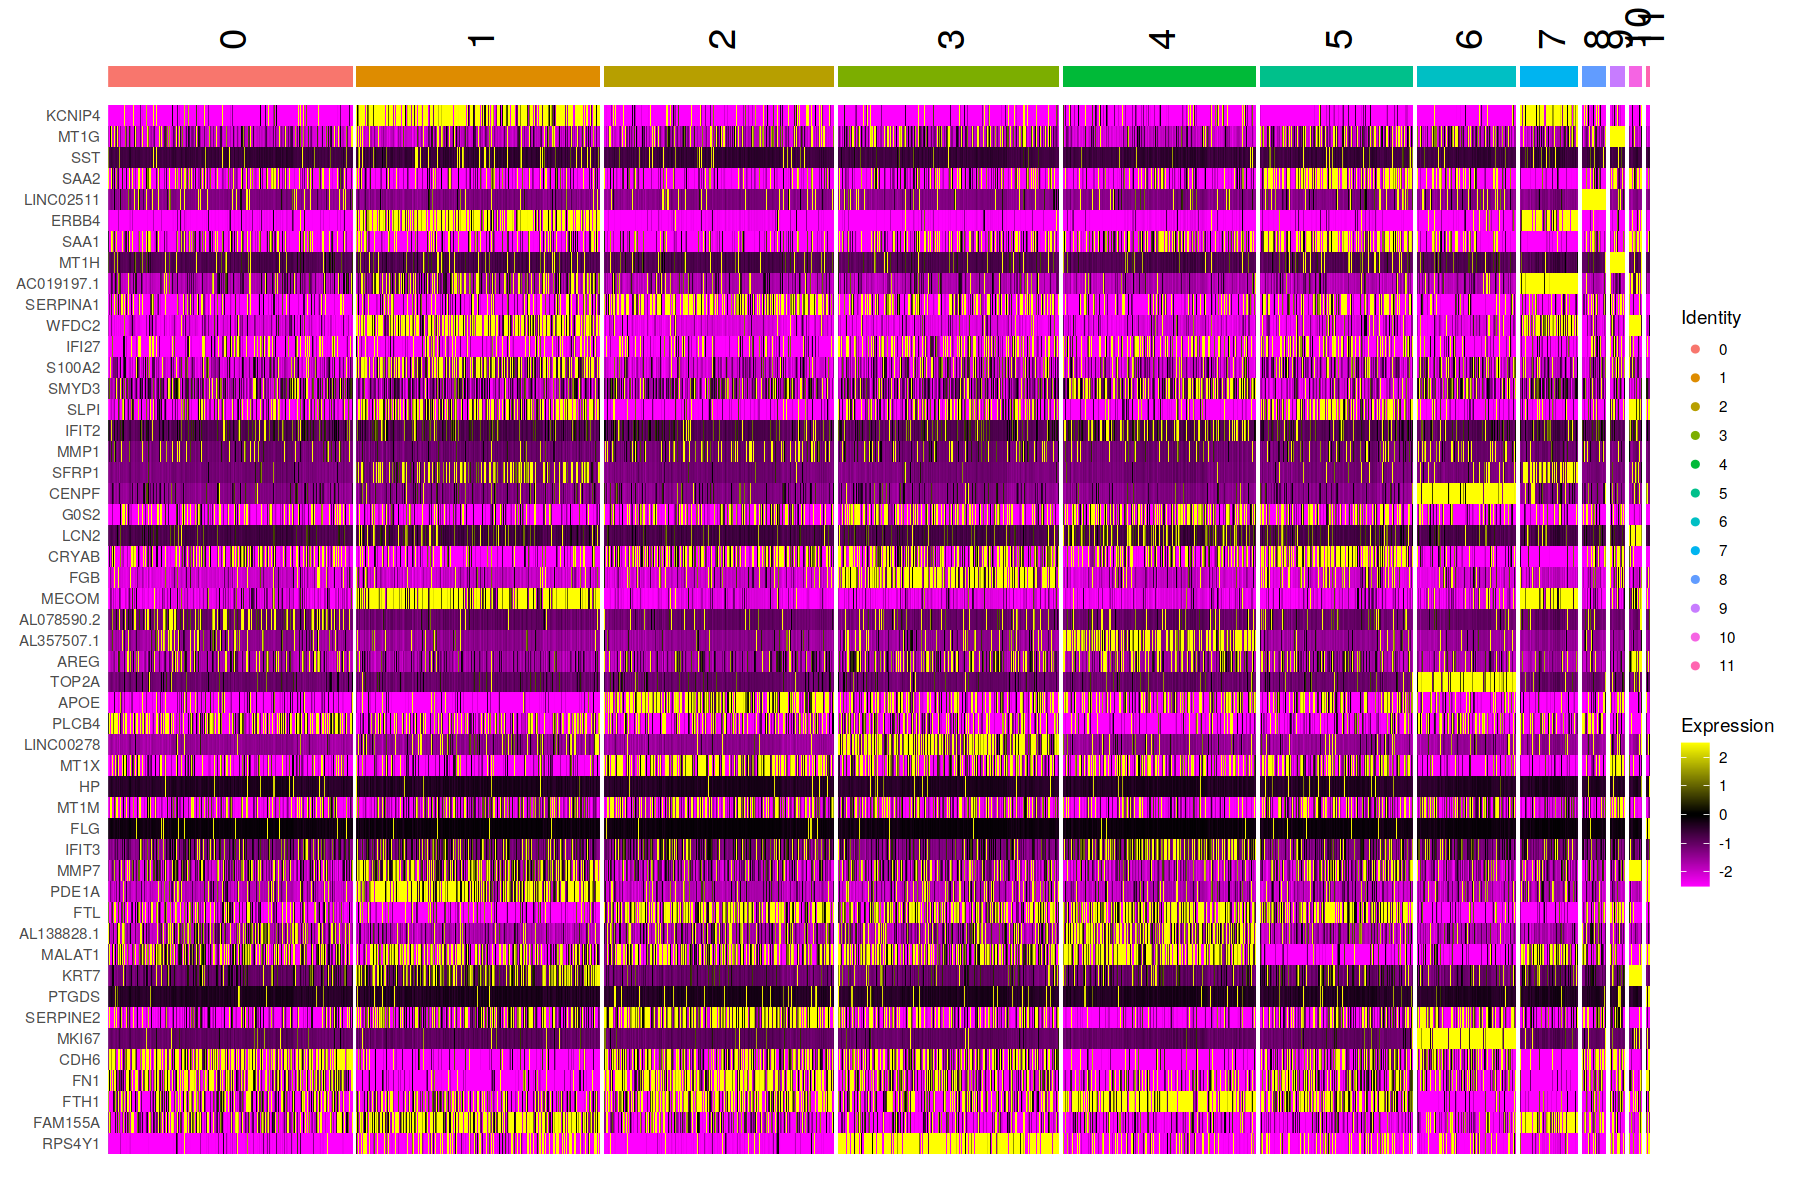

In [ ]:
options(repr.plot.width=15, repr.plot.height=10)

DoHeatmap(
    seurat_combined_singlets, 
    features = top_50, 
    size = 8,
    angle = 90
)


### Plot heatmap for top markers

Warning message in DoHeatmap(seurat_combined_singlets, features = rownames(head(all_markers, :
"The following features were omitted as they were not found in the scale.data slot for the SCT assay: GNB1, RPS26"


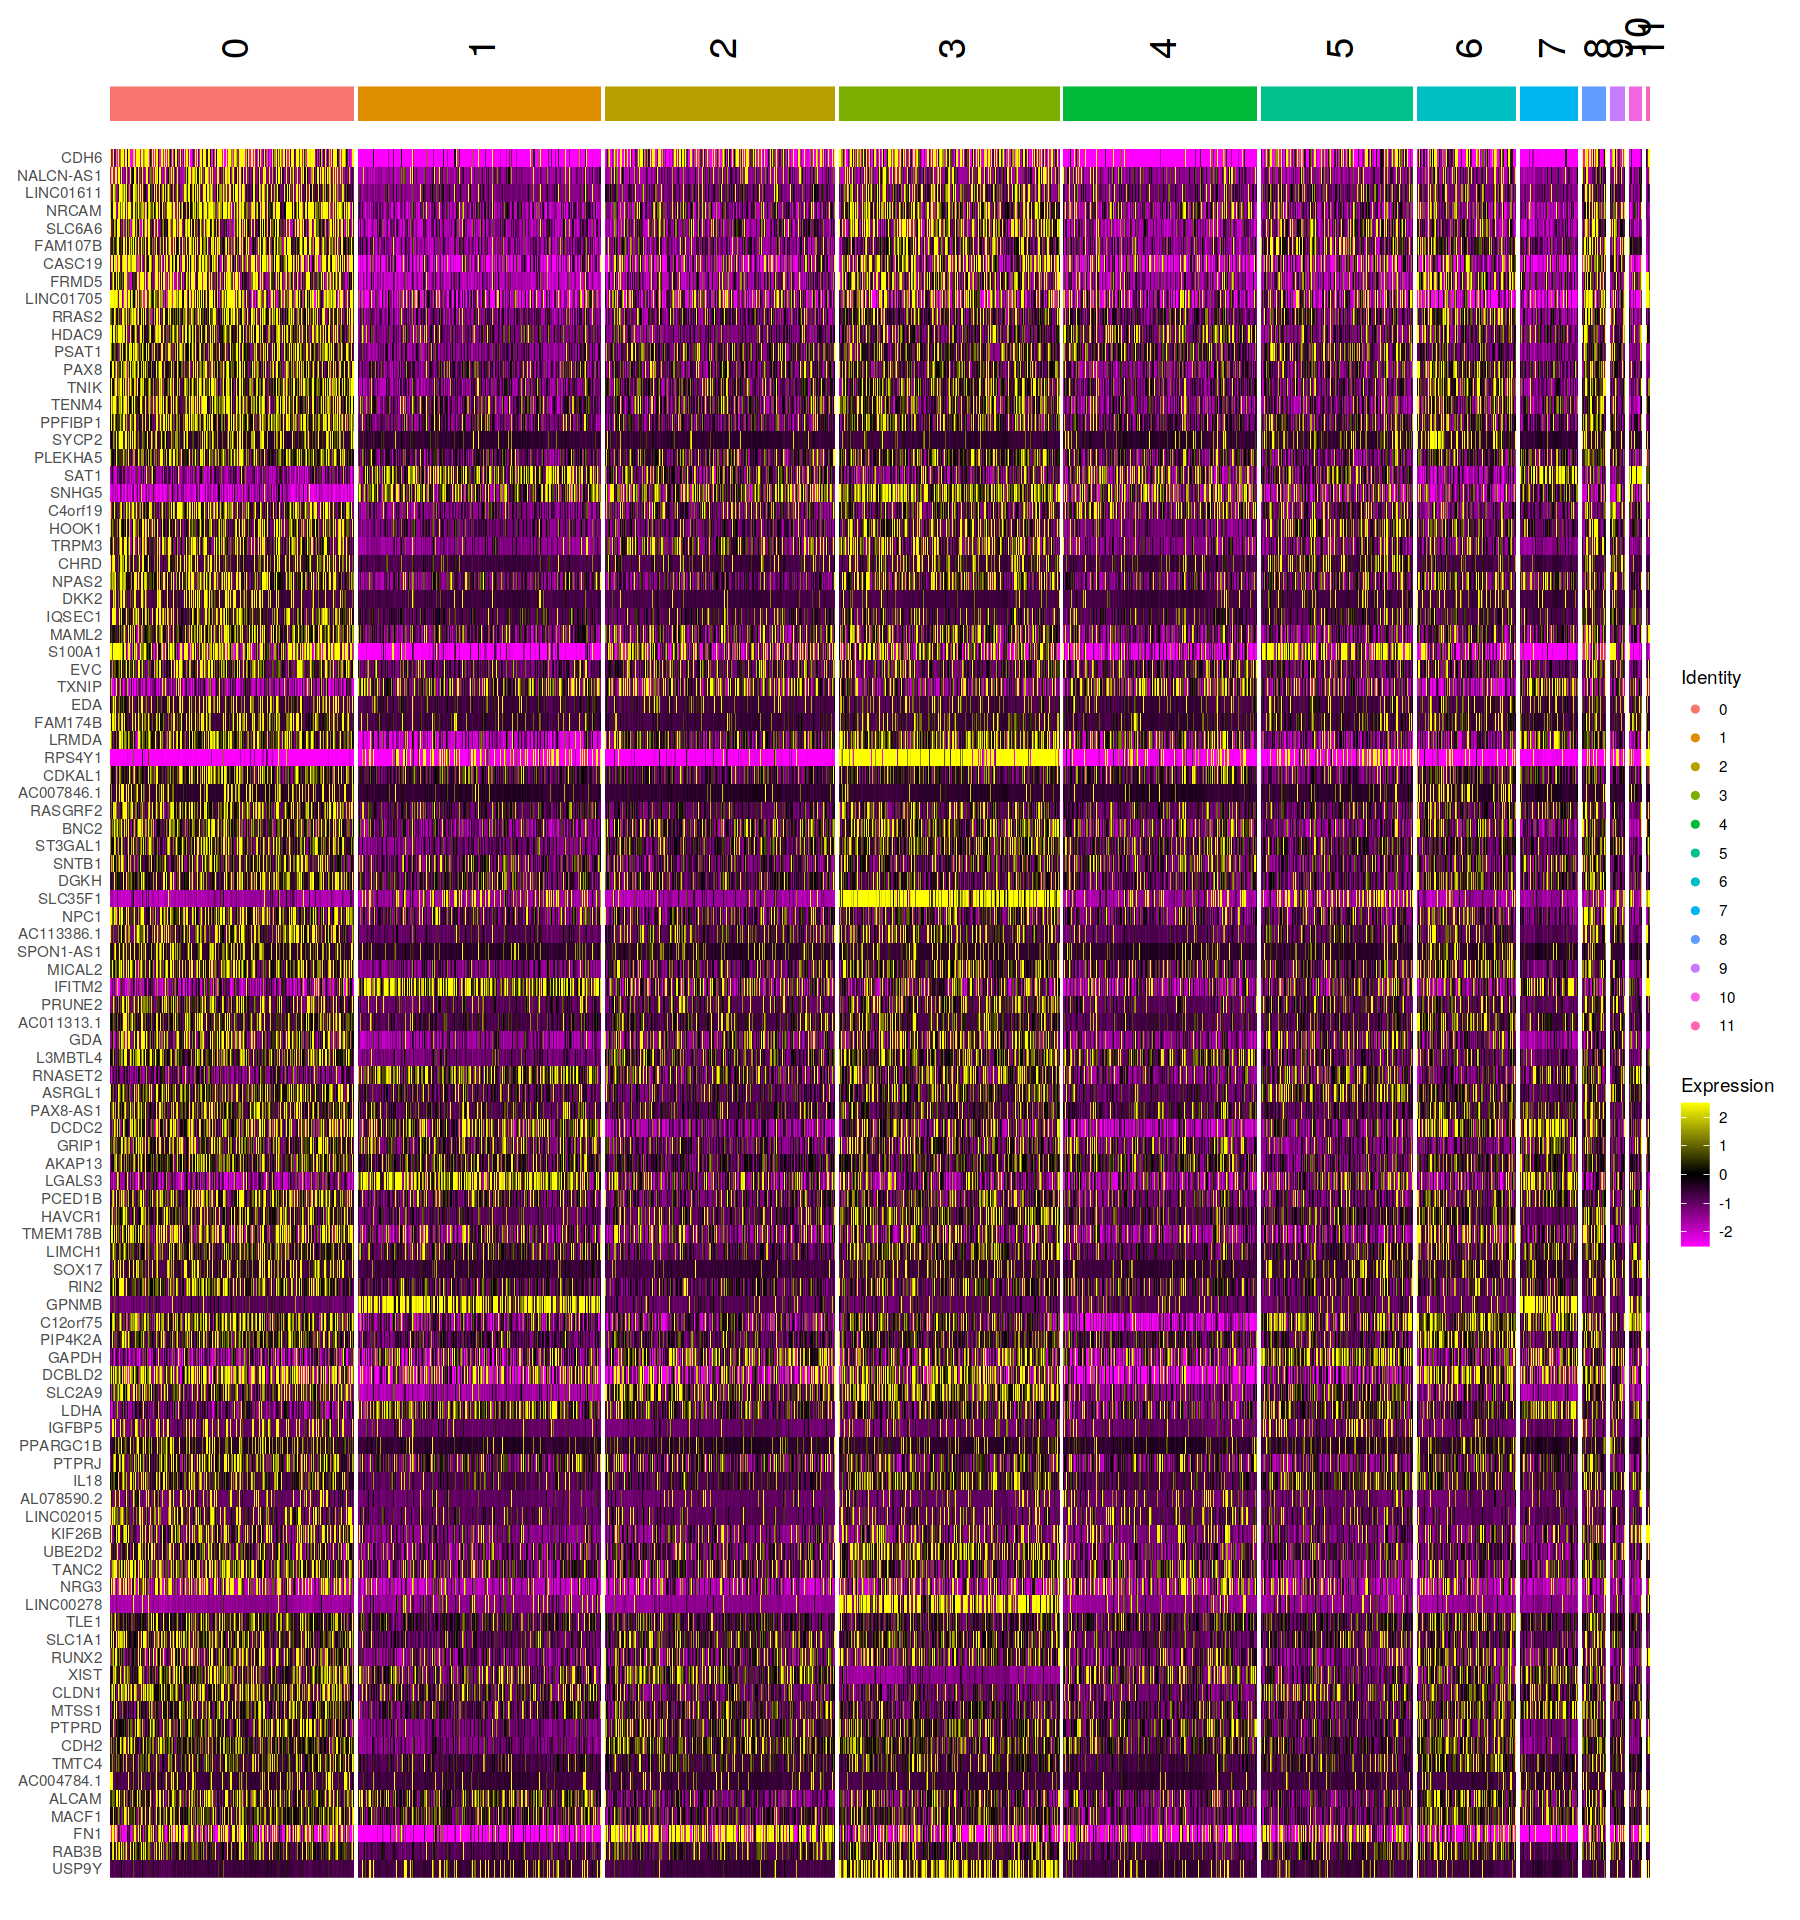

In [ ]:
options(repr.plot.width=15, repr.plot.height=16)

DoHeatmap(
    seurat_combined_singlets, 
    features = rownames(head(all_markers,100)),
    size = 8,
    angle = 90
)

In [ ]:
VariableFeatures(seurat_combined_singlets)[1:100]
head(all_markers)

[1] "KCNIP4"     "MT1G"       "SST"        "SAA2"       "LINC02511" 
  [6] "ERBB4"      "SAA1"       "MT1H"       "AC019197.1" "SERPINA1"  
 [11] "WFDC2"      "IFI27"      "S100A2"     "SMYD3"      "SLPI"      
 [16] "IFIT2"      "MMP1"       "SFRP1"      "CENPF"      "G0S2"      
 [21] "LCN2"       "CRYAB"      "FGB"        "MECOM"      "AL078590.2"
 [26] "AL357507.1" "AREG"       "TOP2A"      "APOE"       "PLCB4"     
 [31] "LINC00278"  "MT1X"       "HP"         "MT1M"       "FLG"       
 [36] "IFIT3"      "MMP7"       "PDE1A"      "FTL"        "AL138828.1"
 [41] "MALAT1"     "KRT7"       "PTGDS"      "SERPINE2"   "MKI67"     
 [46] "CDH6"       "FN1"        "FTH1"       "FAM155A"    "RPS4Y1"    
 [51] "MT1E"       "S100A9"     "SERPINE1"   "KITLG"      "ZFPM2"     
 [56] "KRT19"      "PLIN2"      "IGFBP5"     "SLC12A3"    "BST2"      
 [61] "CXCL14"     "SPP1"       "RRAD"       "SERPINA3"   "IFIT1"     
 [66] "ITGA2"      "AC079352.1" "ISG15"      "ANGPTL4"    "FRMPD4"    
 [71] "PLCG2"      "RSAD2"      "FXYD2"      "AL079338.1" "HMOX1"     
 [76] "MT2A"       "ASPM"       "AKAP12"     "XKR4"       "NALCN-AS1" 
 [81] "ADAMTS3"    "ZFPM2-AS1"  "DCN"        "MUC1"       "SOD2"      
 [86] "RARRES2"    "NEAT1"      "KLK7"       "CSGALNACT1" "MAL"       
 [91] "RBP4"       "SPON1"      "NRG3"       "AC091576.1" "LRP1B"     
 [96] "S100A6"     "ADIRF"      "TFPI2"      "SCEL"       "LSAMP"

p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene     
CDH6      0     1.11       0.99  0.92  0         0       CDH6     
NALCN-AS1 0     1.10       0.71  0.42  0         0       NALCN-AS1
LINC01611 0     1.06       0.76  0.45  0         0       LINC01611
NRCAM     0     1.01       1.00  0.96  0         0       NRCAM    
SLC6A6    0     1.01       0.94  0.83  0         0       SLC6A6   
FAM107B   0     0.97       0.97  0.91  0         0       FAM107B

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
"ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


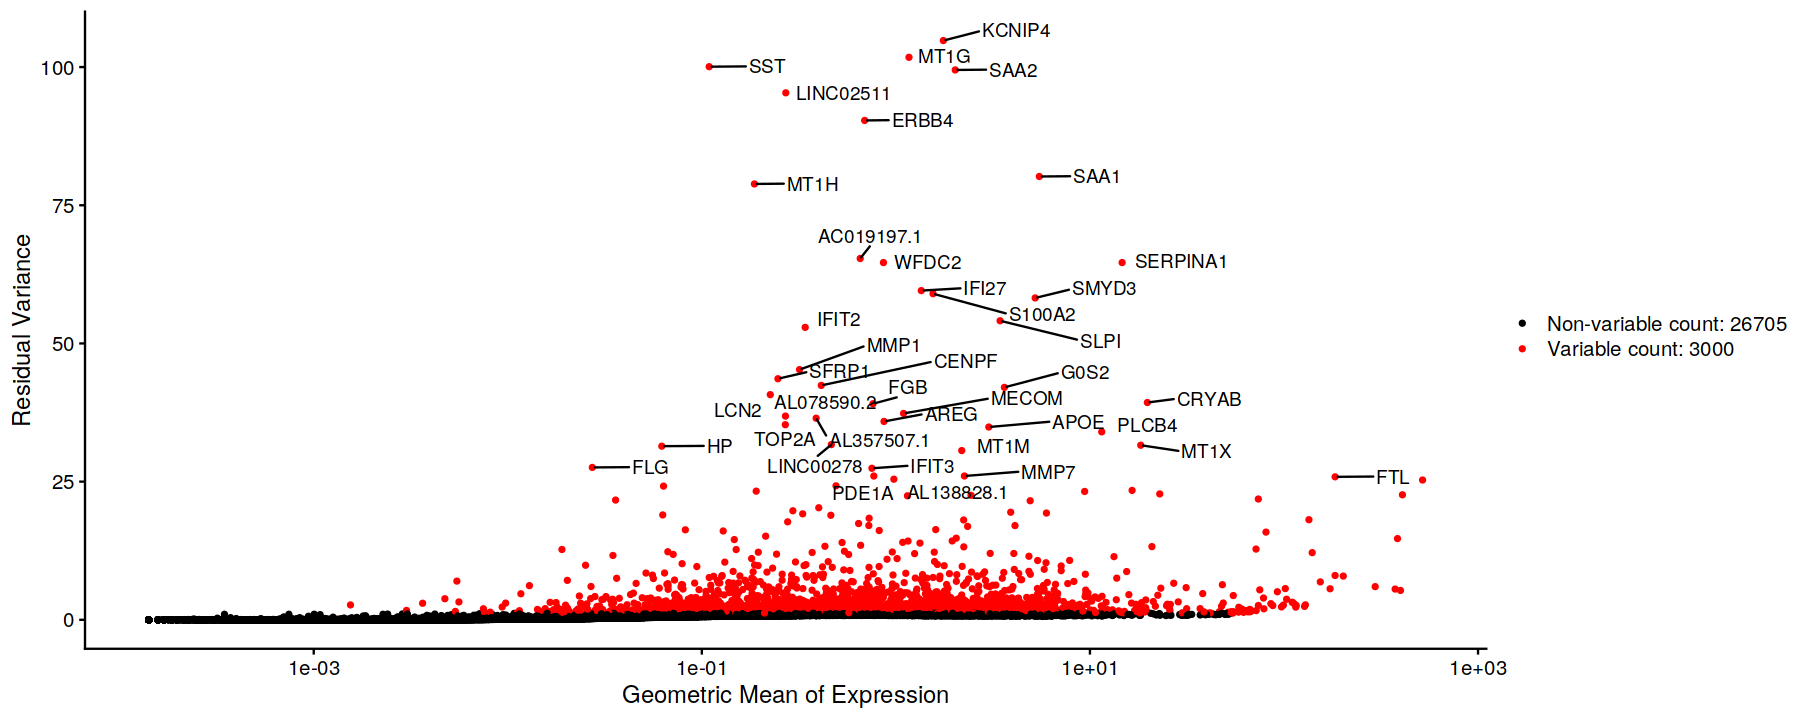

In [ ]:
options(repr.plot.width=15, repr.plot.height=6)
p1 <- VariableFeaturePlot(seurat_combined_singlets)
LabelPoints(plot = p1, points = top_40, repel = TRUE)

# Test HTOdemux for guide assignment

Normalize sgRNA assay using CLR method

In [ ]:
seurat_combined_singlets <- NormalizeData(
    seurat_combined_singlets, 
    assay = "sgRNA", 
    normalization.method = "CLR"
)

Normalizing across features



Filter out low count cells and constructs

In [ ]:
cells = Cells(seurat_combined_singlets) 
filter_out_DE2_1 = cells != "ACTTCCGGTGTATTGC-1_4"
cells_wo_DE2_1   = cells[filter_out_DE2_1]
seurat_lowcounts_filtered <- subset(seurat_combined_singlets, cells = cells_wo_DE2_1)
#seurat_lowcounts_filtered <- subset(seurat_combined_singlets, subset = nCount_sgRNA > 100)

HTODemux(
  seurat_combined_singlets,
  assay = "sgRNA",
  positive.quantile = 0.99,
  seed = 5296021,
  verbose = TRUE
)

# init = 30,
#   nstarts = 100,
#   kfunc = "clara",
#   nsamples = 100,

ERROR: Error in HTODemux(seurat_combined_singlets, assay = "sgRNA", positive.quantile = 0.99, : Cells with zero counts exist as a cluster.


In [ ]:
length(Cells(seurat_lowcounts_filtered))
length(Cells(seurat_combined_singlets))
sum(filter_out_DE2_1)
length(cells_wo_DE2_1)

[1] 21362

[1] 21363

[1] 21362

[1] 21362

In [ ]:
HTOHeatmap(
  object,
  assay = "sgRNA",
  classification = paste0(assay, "_classification"),
  global.classification = paste0(assay, "_classification.global"),
  ncells = 5000,
  singlet.names = NULL,
  raster = TRUE
)

# Debug

In [ ]:
head(seurat_combined_singlets,2)

nCount_RNA nFeature_RNA nCount_sgRNA nFeature_sgRNA
AGCTCAATCGTAGGGA-1_1 32644      5712           92          9            
AAACGCTCAGTTAGAA-1_1 44827      7247         3081         27            
                     nCount_SCT nFeature_SCT orig.ident       library
AGCTCAATCGTAGGGA-1_1 28010      5671         Screen1_66guides Lib_1  
AAACGCTCAGTTAGAA-1_1 27830      6556         Screen1_66guides Lib_1  
                     percent.mt PS_call                 construct_call
AGCTCAATCGTAGGGA-1_1 4.8        C15orf40_1a             C15orf40_1    
AAACGCTCAGTTAGAA-1_1 9.7        C15orf40_1a|C15orf40_1b C15orf40_1    
                     target_call nCalled_Constructs nPS_calls
AGCTCAATCGTAGGGA-1_1 C15orf40    1                  1        
AAACGCTCAGTTAGAA-1_1 C15orf40    1                  2        
                     nCalled_sgRNA_UMIs status  donor SCT_snn_res.0.5
AGCTCAATCGTAGGGA-1_1 57                 singlet 3     2              
AAACGCTCAGTTAGAA-1_1 1302|1753          singlet 0     3              
                     seurat_clusters
AGCTCAATCGTAGGGA-1_1 2              
AAACGCTCAGTTAGAA-1_1 3

In [ ]:
head(df_construct_counts[order(df_construct_counts$Count),])
nrow(df_construct_counts)

Construct Count
31 DE2_1        1 
5  CCCE4_1    925 
21 DE13_1     949 
46 FTH1_1     971 
22 DE13_2    1028 
57 MAFF_1    1036

[1] 64

Which cell contains the only DE2_1 construct?

In [ ]:
seurat_combined_singlets@meta.data[grepl("DE2_1",seurat_combined_singlets$construct_call),]

nCount_RNA nFeature_RNA nCount_sgRNA nFeature_sgRNA
ACTTCCGGTGTATTGC-1_4 56211      8390         18513        99            
                     nCount_SCT nFeature_SCT orig.ident       library
ACTTCCGGTGTATTGC-1_4 27880      6562         Screen1_66guides Lib_4  
                     percent.mt
ACTTCCGGTGTATTGC-1_4 12        
                     PS_call                                                                                                                                                                                                                                                                                                                                                                                                                                        
ACTTCCGGTGTATTGC-1_4 C15orf40_1a|C15orf40_1b|FTH1_1a|FTH1_2a|PLIN3_1a|PLIN3_1b|PLIN3_2a|PLIN3_2b|TKT_2a|LGALS3_1b|LGALS3_2b|CSTB_2a|CSTB_2b|CTSB_1a|CTSB_1b|CTSB_2a|CTSB_2b|KLF6_1a|KLF6_1b|DE1_2b|DE2_1a|DE2_1b|DE4_2a|DE5_1b|DE6_1a|DE6_1b|DE6_2a|DE7_1a|DE7_1b|DE8_2a|DE8_2b|DE9_1a|DE10_2a|DE10_2b|DE11_1a|DE11_1b|DE11_2a|DE11_2b|DE12_1a|DE12_2a|DE12_2b|DE13_1a|DE13_1b|DE15_1a|DE15_1b|DE15_2b|DE16_1b|GDOC1_1a|GDOC1_1b|GDOC2_1a|GDOC2_1b|CCCE1_1a|CCCE1_1b
                     construct_call                                                                                                                                                                                                                           
ACTTCCGGTGTATTGC-1_4 C15orf40_1|FTH1_1|FTH1_2|PLIN3_1|PLIN3_2|TKT_2|LGALS3_1|LGALS3_2|CSTB_2|CTSB_1|CTSB_2|KLF6_1|DE1_2|DE2_1|DE4_2|DE5_1|DE6_1|DE6_2|DE7_1|DE8_2|DE9_1|DE10_2|DE11_1|DE11_2|DE12_1|DE12_2|DE13_1|DE15_1|DE15_2|DE16_1|GDOC1_1|GDOC2_1|CCCE1_1
                     target_call                                                                                                                  
ACTTCCGGTGTATTGC-1_4 C15orf40|FTH1|PLIN3|TKT|LGALS3|CSTB|CTSB|KLF6|DE1|DE2|DE4|DE5|DE6|DE7|DE8|DE9|DE10|DE11|DE12|DE13|DE15|DE16|GDOC1|GDOC2|CCCE1
                     nCalled_Constructs nPS_calls
ACTTCCGGTGTATTGC-1_4 33                 53       
                     nCalled_sgRNA_UMIs                                                                                                                                                                                    
ACTTCCGGTGTATTGC-1_4 130|214|58|93|275|259|31|36|141|37|32|2455|51|1092|320|319|28|410|383|198|44|31|155|31|721|817|108|1500|200|771|428|288|15|29|763|9|309|369|162|41|365|269|280|333|186|121|153|926|1043|235|61|427|623
                     status  donor SCT_snn_res.0.5 seurat_clusters
ACTTCCGGTGTATTGC-1_4 singlet 2     3               3

In [ ]:
#subset(seurat_combined_singlets, subset = 
cells = Cells(seurat_combined_singlets) 
filter_out_DE2_1 = cells != "ACTTCCGGTGTATTGC-1_4"
cells(filter_out_DE2_1)


AGCTCAATCGTAGGGA-1_1 AAACGCTCAGTTAGAA-1_1 AAAGGATAGCGATTCT-1_1 
                   2                    3                    2 
ATCGGCGGTCTAGATC-1_1 CAAGAGGCAGTTCTAG-1_1 CCTGCATTCAAGCCAT-1_1 
                   2                    3                    3 
GTAATCGCACATACGT-1_1 GTACAACGTGTGATGG-1_1 GTAGAGGGTCTTTCAT-1_1 
                   1                    3                    5 
GTGAGTTTCCAAGCAT-1_1 TCAGCAAAGTAAATGC-1_1 TCCCACACATGTGCTA-1_1 
                   0                    0                    2 
TTTATGCTCGGTGAAG-1_1 GAAACCTTCAGGTAAA-1_1 TCTTAGTCATAATGAG-1_1 
                   5                    2                    4 
CTTACCGCAGCAGTTT-1_1 GGGATCCCACAAACGG-1_1 CCGGACAGTTTGCCGG-1_1 
                   4                    1                    0 
TTTGGTTCAGATTAAG-1_1 CCAAGCGAGACGGATC-1_1 GAAGAATGTGAGTAGC-1_1 
                   0                    3                    6 
AGTAGCTGTCTTGAAC-1_1 TCAGCAAGTGACAGCA-1_1 GTGTGATCACTATGTG-1_1 
                   1                   11                   10 
GAAATGATCTCATTGT-1_1 TTGTTGTAGACGACGT-1_1 TCGAAGTAGGACTGGT-1_1 
                   0                    5                    5 
TGTTCCGCAAAGGCTG-1_1 GGTTCTCTCGCGATCG-1_1 TATCCTAAGTGGCGAT-1_1 
                   4                    4                    3 
TTTCACAGTGGAGAAA-1_1 CAGCCAGGTAAGTCAA-1_1 GCTACCTGTGTCCTAA-1_1 
                   1                    3                    4 
CATTCTAAGTTAACAG-1_1 TAGGGTTAGGAGGGTG-1_1 ATTTCACGTAGAGATT-1_1 
                   0                    2                    3 
TGGATGTGTTAGAGAT-1_1 GGTCTGGAGGACGGAG-1_1 AGTGTTGCAGACAAGC-1_1 
                   6                    1                    4 
TGGGTTAAGGCGAAGG-1_1 ATTCATCAGGCCTTCG-1_1 TGGAACTCAGGTTCGC-1_1 
                   1                    2                    5 
CTCCGATTCACCCTGT-1_1 CTGCAGGCAGAACTTC-1_1 GGAGCAACATACCACA-1_1 
                   6                    4                    1 
CTGAGCGCACAGTCAT-1_1 GATTCGATCCGGTAGC-1_1 GTCACGGCAACGCATT-1_1 
                   2                    0                    7 
GACTATGTCGGAGTAG-1_1 TACTTGTGTACTCCGG-1_1 CTAGGTAAGCCTTCTC-1_1 
                   0                    3                    0 
GGAAGTGGTCTGTGAT-1_1 AGTCAACTCAAGATAG-1_1 TGCGGCACAAGCTACT-1_1 
                   3                    0                    3 
TAATCTCGTGTTAAAG-1_1 TGTTACTAGTTTGGCT-1_1 GTTCCGTCAAGACAAT-1_1 
                   0                    0                    1 
CGTTCTGCAGCTGTCG-1_1 GACCTTCTCGGACCAC-1_1 AGGAATATCGGTGTTA-1_1 
                   8                    7                    0 
AAAGTCCGTTGTGGAG-1_1 ACCCTTGCAACGAGGT-1_1 ATCCTATTCTGCCCTA-1_1 
                   3                    3                    2 
ACCAACACAACCGATT-1_1 AATTCCTCAGGTTACT-1_1 TGTGATGCAGCTGTCG-1_1 
                   4                    0                    4 
ATCAGGTTCCATGATG-1_1 CAATACGGTTTACGTG-1_1 CTGCATCCACAGCTTA-1_1 
                   4                    5                    5 
TAGACCAAGAGAGGGC-1_1 TCCAGAACAGCAAGAC-1_1 TATCCTAAGTTGGCTT-1_1 
                   3                    1                    0 
GGGTAGATCGGCTTCT-1_1 CACTGGGTCTCCATAT-1_1 CAACCAATCCATTGTT-1_1 
                   3                    4                    5 
CCCGAAGAGGAGATAG-1_1 GCCATTCAGCCGTAAG-1_1 GCTTCACGTCGTGGAA-1_1 
                   1                    4                    1 
ATACTTCCAATTGCAC-1_1 ACCTGTCCAAGACCTT-1_1 GTTAGACAGGTATCTC-1_1 
                   0                    2                    2 
CAACGGCGTGTCCCTT-1_1 CCTCCAAGTTGCGAAG-1_1 GCTTTCGGTCTTGCTC-1_1 
                   4                    5                    5 
TGCGATAGTAATGATG-1_1 CTCTCAGGTCTGTCCT-1_1 CACAGGCAGGAAAGTG-1_1 
                   5                    6                    1 
TGAGGAGGTAACATCC-1_1 TTACCGCGTCACTCAA-1_1 CATGGTATCAGCTGAT-1_1 
                   1                    5                    0 
TACTTGTCATTGCAAC-1_1 CTCTCAGAGTTCTACG-1_1 CTTGAGAGTCGACTGC-1_1 
                   3                    0                    1 
AGGAGGTTCGCAGATT-1_1 TCCTCTTGTGA

In [ ]:
min(seurat_combined_singlets$nCount_sgRNA)

[1] 10